# T cell epitopes of SARS-CoV2

## Methods

* Predict MHC-I binders for sars-cov2 reference sequences (S and N important)
* Align with sars-cov and get conserved epitopes.
* Best alleles to use?
* Multiple sequence alignment of each protein to reference
* find conservation of binders with closest peptide in each HCov sequence and determine identity

## References

* J. Mateus et al., “Selective and cross-reactive SARS-CoV-2 T cell epitopes in unexposed humans,” Science (80-. )., vol. 3871, no. August, p. eabd3871, Aug. 2020.
* S. F. Ahmed, A. A. Quadeer, and M. R. McKay, “Preliminary Identification of Potential Vaccine Targets for the COVID-19 Coronavirus (SARS-CoV-2) Based on SARS-CoV Immunological Studies.,” Viruses, vol. 12, no. 3, 2020.
* A. Grifoni et al., “A sequence homology and bioinformatic approach can predict candidate targets for immune responses to SARS-CoV-2,” Cell Host Microbe, pp. 1–10, 2020.
* V. Baruah and S. Bose, “Immunoinformatics-aided identification of T cell and B cell epitopes in the surface glycoprotein of 2019-nCoV,” J. Med. Virol., no. February, pp. 495–500, 2020.

## Common coronoviruses

* https://www.cdc.gov/coronavirus/types.html


In [1]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict, defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.width', 180)
import epitopepredict as ep
from epitopepredict import base, sequtils, plotting, peptutils, analysis
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl
import pylab as plt
import pathogenie
from Bio import SeqIO,AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

## load ref genomes

In [2]:
labels = {'sars':'NC_004718.3','scov2':'NC_045512.2','229E':'NC_002645.1','NL63':'NC_005831.2','OC43':'NC_006213.1','HKU1':'NC_006577.2'}
genomes = []
for l in labels:
    df = ep.genbank_to_dataframe(labels[l]+'.gb',cds=True)
    df['label'] = l
    genomes.append(df)
genomes = pd.concat(genomes)
scov2_df = genomes[genomes.label=='scov2']
scov2_df = scov2_df.drop_duplicates('locus_tag')
#print (genomes[['label','gene','product','length']])

In [3]:
def get_seqs(gene):
    seqs = []
    sub = genomes[genomes['gene']==gene]
    for i,r in sub.iterrows():
        s=SeqRecord(Seq(r.translation),id=r.label)
        seqs.append(s)
    return seqs
seqs=get_seqs('S')

## find orthologs in each genome
### blast the genomes to find corresponding protein as names are ambigious

In [4]:
pathogenie.tools.dataframe_to_fasta(genomes, idkey='locus_tag', descrkey='product', outfile='proteins.fa')
pathogenie.tools.make_blast_database('proteins.fa', dbtype='prot')

def get_orthologs(gene):
    sub = scov2_df[scov2_df['gene']==gene].iloc[0]    
    rec = SeqRecord(Seq(sub.translation),id=sub.gene)
    bl = pathogenie.tools.blast_sequences('proteins.fa', [rec], maxseqs=10, evalue=1e-4,
                              cmd='blastp', threads=4)
    bl = bl.drop_duplicates('sseqid')
    #print (bl.sseqid)
    found = genomes[genomes.locus_tag.isin(bl.sseqid)].drop_duplicates('locus_tag')
    #print (found)
    recs = pathogenie.tools.dataframe_to_seqrecords(found,
                            seqkey='translation',idkey='label',desckey='product')
    return recs

seqs = get_orthologs('S')
aln = pathogenie.clustal_alignment(seqs=seqs)
print (aln)

SingleLetterAlphabet() alignment with 6 rows and 1475 columns
--MFIFLLFLT----------------LTSGSDLDRCTTFDDVQ...HYT sars
--MFVFLVLLP----------------LVSSQCVN--LTTRTQL...HYT scov2
-MFLILLISLPTAFAVIGD-------LKCTSDNINDKDTGPPPI...D-- OC43
--MLLIIFILPTTLAVIGD-------FNCTNFAINDLNTTVPRI...D-- HKU1
--------------------------------------------...HIQ 229E
MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLL...HVQ NL63


In [6]:
spikesars = SeqIO.to_dict(seqs)['sars'].seq
spikesars

Seq('MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYL...HYT', None)

In [5]:
sc2 = ep.genbank_to_dataframe('NC_045512.2.gb',cds=True)
sc2 = sc2.drop_duplicates('gene')

## predict MHC-I and MHC-II epitopes

In [6]:
m1_alleles = ep.get_preset_alleles('broad_coverage_mhc1')
m2_alleles = ep.get_preset_alleles('mhc2_supertypes')

In [ ]:
P1 = base.get_predictor('netmhcpan') 
P1.predict_sequences(sc2, alleles=m1_alleles,threads=10,path='scov2_netmhcpan',length=9,overwrite=False)
P1.load(path='scov2_netmhcpan')
pb1 = P1.promiscuous_binders(n=3, cutoff=.95)

In [8]:
P2 = base.get_predictor('netmhciipan') 
P2.predict_sequences(sc2, alleles=m2_alleles,threads=10,path='scov2_netmhciipan',length=15,overwrite=False,verbose=True)

name                      allele           top peptide        score
predictions done for 11 sequences in 8 alleles
results saved to /home/damien/gitprojects/epitopepredict/examples/scov2_netmhciipan


In [9]:
P3 = base.get_predictor('tepitope') 
P3.predict_sequences(sc2, alleles=m2_alleles,threads=10,path='scov2_tepitope',length=15,overwrite=False)
P3.load(path='scov2_tepitope')

predictions done for 11 sequences in 8 alleles
results saved to /home/damien/gitprojects/epitopepredict/examples/scov2_tepitope


In [11]:
P2.load(path='scov2_netmhciipan')
pb2 = P2.promiscuous_binders(n=3, cutoff=.95, limit=70)
#rb2 = P2.promiscuous_binders(n=3, cutoff_method='rank', cutoff=40)
pb2.name.value_counts()
#pb3 = P3.promiscuous_binders(n=3, cutoff=50, cutoff_method='rank', limit=50)
#pb3.name.value_counts()

GU280_gp01    70
GU280_gp02    70
GU280_gp03    38
GU280_gp05    30
GU280_gp10    19
GU280_gp07    14
GU280_gp04    11
GU280_gp09    11
GU280_gp11    10
GU280_gp06     9
Name: name, dtype: int64

## conservation: find identity to closest peptide in each HCoV sequence 

In [ ]:
import difflib

def get_conservation(x, w):    
    m = difflib.get_close_matches(x, w, n=1, cutoff=.67)
    if len(m)==0:
        return 0
    else:
        m=m[0]
        s = difflib.SequenceMatcher(None, x, m)
        return s.ratio()

def find_epitopes_conserved(pb,gene,locus_tag):
    
    seqs = get_orthologs(gene)
    df = pb[pb.name==locus_tag]
    #print (df)
    print (len(seqs),len(df))
    s=seqs[0]
    for s in seqs:
        if s.id == 'scov2': 
            continue
        w,ss = peptutils.create_fragments(seq=str(s.seq), length=11)
        df.loc[:,s.id] = df.peptide.apply(lambda x: get_conservation(x, w),1)

    df.loc[:,'total'] = df[df.columns[8:]].sum(1)
    df = df.sort_values('total',ascending=False)
    df = df[df.total>0]
    df = df.round(2)
    return df

df = find_epitopes_conserved(pb2, 'S','GU280_gp02')
#df.to_csv('S_netmhciipan_conserved.csv')

## Find conserved predicted epitopes in all proteins

In [ ]:
res=[]
for i,r in scov2_df.iterrows():
    print (r.locus_tag,r.gene)    
    df = find_epitopes_conserved(pb2,r.gene,r.locus_tag)
    df['gene'] = r.gene
    res.append(df)
res = pd.concat(res).sort_values('total',ascending=False).dropna().reset_index()
print (len(res),len(pb2))
res.to_csv('scov2_netmhciipan_conserved.csv')

In [15]:
cols = ['gene','peptide','pos','alleles','sars','229E','NL63','OC43','HKU1']
h=res[:30][cols].style.background_gradient(cmap="ocean_r",subset=['sars','229E','NL63','OC43','HKU1']).set_precision(2)

#res[:30][cols]

## Compare predictions to mateus exp results

In [18]:
s1 = pd.read_csv('mateus_hcov_reactive.csv')
hits=[]
w = list(res.peptide)
for i,r in s1.iterrows():    
    m = difflib.get_close_matches(r.Sequence, w, n=2, cutoff=.6)
    #print (r.Sequence,m,r.Protein)
    if len(m)>0:
        hits.append(m)
    else:
        hits.append(None)
        
s1['hit'] = hits
display(s1)
print (len(s1.hit.dropna())/len(s1))

,Sequence,Protein,Start,"""+""/tested",SFC,CD4R-30,CD4S-31,hit
0,PSGTWLTYTGAIKLD,N,326,1/15,1067,Yes,No,[GTWLTYTGAIKLDDK]
1,SFIEDLLFNKVTLAD,S,816,7/15,30487,No,Yes,"[FIEDLLFNKVTLADA, DLLFNKVTLADAGFI]"
2,YEQYIKWPWYIWLGF,S,1206,1/17,200,No,Yes,None
3,VLKKLKKSLNVAKSE,nsp8,3976,1/16,5660,Yes,No,"[VVLKKLKKSLNVAKS, EVVLKKLKKSLNVAK]"
4,KLLKSIAATRGATVV,nsp12,4966,1/17,187,Yes,No,[RQFHQKLLKSIAATR]
5,EFYAYLRKHFSMMIL,nsp12,5136,2/18,787,Yes,No,"[NEFYAYLRKHFSMMI, YLRKHFSMMILSDDA]"
6,LMIERFVSLAIDAYP,nsp12,5246,2/17,3870,Yes,No,None
7,TSHKLVLSVNPYVCN,nsp13,5361,1/17,160,Yes,No,None
8,NVNRFNVAITRAKVG,nsp13,5881,1/18,760,Yes,No,[VNRFNVAITRAKVGI]


0.6666666666666666


## check epitope selection method

Promiscuous binders are those high scoring above some threshold in multiple alleles. There are several ways to select them that can give different results. By default epitopepredict selects those in each allele above a percentile score cutoff and then counts how many alleles each peptide is present in. We can also limit our set in each protein across a genome to prevent large proteins dominating the list. We can also select by score and protein rank. The overlap is shown in the venn diagram.

In [23]:
reload(base)
P = base.get_predictor('tepitope') 
P.predict_sequences(sc2, alleles=m2_alleles[:4],names=['GU280_gp01','GU280_gp02','GU280_gp03','GU280_gp04'],threads=10,length=9)
pb= P.promiscuous_binders(n=2, cutoff=.98, limit=20)
pb.name.value_counts()

predictions done for 4 sequences in 4 alleles


GU280_gp01    20
GU280_gp02     9
GU280_gp03     5
GU280_gp04     3
Name: name, dtype: int64

In [20]:
rb= P.promiscuous_binders(n=3, cutoff_method='rank',cutoff=30,limit=20)
rb.name.value_counts()

GU280_gp04    20
GU280_gp03    19
GU280_gp02     6
GU280_gp01     4
Name: name, dtype: int64

In [21]:
sb= P.promiscuous_binders(n=2, cutoff_method='score',cutoff=3.5,limit=20)
sb.name.value_counts()

GU280_gp01    20
GU280_gp02    13
GU280_gp04     6
GU280_gp03     3
Name: name, dtype: int64

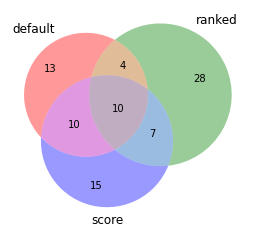

In [22]:
from matplotlib_venn import venn3
ax = venn3((set(pb.peptide),set(rb.peptide),set(sb.peptide)), set_labels = ('default', 'ranked', 'score'))

In [168]:
b=P.get_binders(cutoff=10, cutoff_method='rank')

In [194]:
func = max
s=b.groupby(['peptide','pos','name']).agg({'allele': pd.Series.count,
             'core': base.first, P.scorekey:[func,np.mean],
             'rank': np.median})
s.columns = s.columns.get_level_values(1)
s.rename(columns={'max': P.scorekey, 'count': 'alleles','median':'median_rank',
                 'first':'core'}, inplace=True)
s = s.reset_index()
s
s.name.value_counts()

GU280_gp01    39
GU280_gp02    35
GU280_gp03    29
GU280_gp04    20
Name: name, dtype: int64

In [197]:
s=s.groupby('name').head(10)
s.name.value_counts()

GU280_gp03    10
GU280_gp02    10
GU280_gp01    10
GU280_gp04    10
Name: name, dtype: int64